**HuggingFace Transformers**

🤗 Transformers (formerly known as pytorch-transformers and pytorch-pretrained-bert) provides general-purpose architectures (BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet…) for Natural Language Understanding (NLU) and Natural Language Generation (NLG) with over 32+ pretrained models in 100+ languages and deep interoperability between TensorFlow 2.0 and PyTorch.

In [1]:
!pip install transformers
import transformers

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

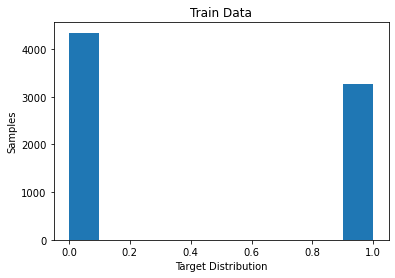

In [3]:
import matplotlib.pyplot as plt
plt.title('Train Data')
plt.xlabel('Target Distribution')
plt.ylabel('Samples')
plt.hist(train.target)
plt.show()

**Pre-Processing** (Optional)

1--> Removing Contraction (Decontraction)

2--> Dealing with HashTags

3--> Removing URLs and Email

4--> Removing Stopwords and Lemmatization



In [4]:

# def decontracted(phrase):
#     # specific
#     phrase = re.sub(r"won\'t", "will not", phrase)
#     phrase = re.sub(r"can\'t", "can not", phrase)

#     # general
#     phrase = re.sub(r"n\'t", " not", phrase)
#     phrase = re.sub(r"\'re", " are", phrase)
#     phrase = re.sub(r"\'s", " is", phrase)
#     phrase = re.sub(r"\'d", " would", phrase)
#     phrase = re.sub(r"\'ll", " will", phrase)
#     phrase = re.sub(r"\'t", " not", phrase)
#     phrase = re.sub(r"\'ve", " have", phrase)
#     phrase = re.sub(r"\'m", " am", phrase)
#     return phrase

In [5]:
# import spacy
# import re
# nlp = spacy.load('en')
# def preprocessing(text):
#   text = text.replace('#','')
#   text = decontracted(text)
#   text = re.sub('\S*@\S*\s?','',text)
#   text = re.sub('http[s]?:(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','',text)

#   token=[]
#   result=''
#   text = re.sub('[^A-z]', ' ',text.lower())
  
#   text = nlp(text)
#   for t in text:
#     if not t.is_stop and len(t)>2:  
#       token.append(t.lemma_)
#   result = ' '.join([i for i in token])

#   return result.strip()

In [6]:
# train.text = train.text.apply(lambda x : preprocessing(x))
# test.text = test.text.apply(lambda x : preprocessing(x))

**Loading BertTokenizer**

It is based on WordPiece Approach

In [7]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

In [8]:
import numpy as np
import tensorflow as tf 

**BERT Encoding**

Data is encoded according to BERT requirement.There is a very helpful function called encode_plus provided in the Tokenizer class. It can seamlessly perform the following operations:



*   Tokenize the text
*   Add special tokens - [CLS] and [SEP]

*   Add special tokens - [CLS] and [SEP]
*   create token IDs

*   Pad the sentences to a common length
*   Create attention masks for the above PAD tokens


In [9]:
def bert_encode(data,maximum_length) :
  input_ids = []
  attention_masks = []
  

  for i in range(len(data.text)):
      encoded = tokenizer.encode_plus(
        
        data.text[i],
        add_special_tokens=True,
        max_length=maximum_length,
        pad_to_max_length=True,
        
        return_attention_mask=True,
        
      )
      
      input_ids.append(encoded['input_ids'])
      attention_masks.append(encoded['attention_mask'])
  return np.array(input_ids),np.array(attention_masks)

**Input are 2 Numpy array. Let me briefly go over them:**

1) input_ids : list of token ids to be fed to a model

2) attention_masks: list of indices specifying which tokens should be attended to by the model.The input sequences are denoted by 1 and the padded ones by 0. These masks help to differentiate between the two.

**Note** : Token Ids are not necessary as it is used Two Sentence Problem (To differentiate two sentence)


In [10]:
train_input_ids,train_attention_masks = bert_encode(train,60)
test_input_ids,test_attention_masks = bert_encode(test,60)

**Creating Custom Model**

Base TFBert Model with Dense layer and sigmoid activation as head. 

In [11]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
def create_model(bert_model):
  input_ids = tf.keras.Input(shape=(60,),dtype='int32')
  attention_masks = tf.keras.Input(shape=(60,),dtype='int32')
  
  output = bert_model([input_ids,attention_masks])
  output = output[1]
  output = tf.keras.layers.Dense(32,activation='relu')(output)
  output = tf.keras.layers.Dropout(0.2)(output)

  output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
  model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
  model.compile(Adam(lr=6e-6), loss='binary_crossentropy', metrics=['accuracy'])
  return model



**TFBertModel**

The bare Bert Model transformer outputing raw hidden-states without any specific head on top. 
https://huggingface.co/transformers/model_doc/bert.html#tfbertmodel

In [12]:
from transformers import TFBertModel
bert_model = TFBertModel.from_pretrained('bert-large-uncased')

**Implementing Custom Model**

In [13]:
model = create_model(bert_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 60, 1024), ( 335141888   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           32800       tf_bert_model[0][1]          

**Callbacks** (Optional)

To get best model according to maximum validation accuracy.



In [14]:
# filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
# checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# callbacks_list = [checkpoint]
# add callbacks = callbacks_list to model.fit

**Training**

In [15]:
history = model.fit([train_input_ids,train_attention_masks],train.target,validation_split=0.2, epochs=2,batch_size=10)

Train on 6090 samples, validate on 1523 samples
Epoch 1/2
6090/6090 [==============================] - 198s 33ms/sample - loss: 0.4828 - accuracy: 0.7877 - val_loss: 0.4059 - val_accuracy: 0.8339
Epoch 2/2
6090/6090 [==============================] - 171s 28ms/sample - loss: 0.3662 - accuracy: 0.8589 - val_loss: 0.4473 - val_accuracy: 0.8240


**Testing**

In [16]:
result = model.predict([test_input_ids,test_attention_masks])
result = np.round(result).astype(int)

**Preparing Submission File**

In [17]:
result = pd.DataFrame(result)
submission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
output = pd.DataFrame({'id':submission.id,'target':result[0]})
output.to_csv('submission.csv',index=False)

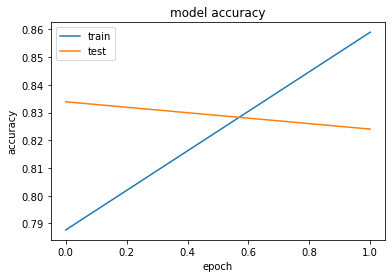

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

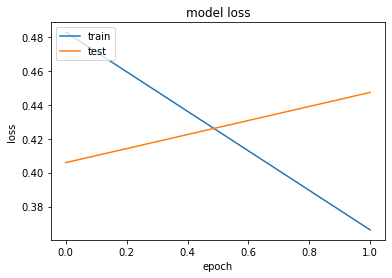

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()